In [1]:
#Extracting file

import os
import zipfile

with zipfile.ZipFile('Alzheimer.zip', 'r') as zip_file:
    zip_file.extractall("./")

In [2]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [3]:
path_train = "/content/Alzheimer_s Dataset/train"
path_test = "/content/Alzheimer_s Dataset/test"

train_rescale = ImageDataGenerator(rescale=1./255)
test_rescale = ImageDataGenerator(rescale=1./255)

train_data = train_rescale.flow_from_directory(
    path_train,
    target_size=(224, 224),
    batch_size=32,
    color_mode = 'grayscale',
    class_mode='sparse'
)


test_data = test_rescale.flow_from_directory(
    path_test,
    target_size=(224, 224),
    batch_size=32,
    color_mode = 'grayscale',
    class_mode='sparse'
)

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [4]:
# Define the input shape for grayscale images
input_shape = (224, 224, 1)

# Load the ResNet50 model without the top layers and specify the input shape
base_model = ResNet50(weights=None, include_top=False, input_tensor=Input(shape=input_shape))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(train_data.num_classes, activation='softmax')(x)

# Define the full model
resnet_model = Model(inputs=base_model.input, outputs=x)

# Compile the model
resnet_model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

import psutil

# Train the model
history = resnet_model.fit(
    train_data,
    validation_data=test_data,
    epochs=10,  # You can adjust the number of epochs
    callbacks=[
        tf.keras.callbacks.LambdaCallback(
            on_epoch_end=lambda epoch, logs: print("CPU utilization: {:.1f}%".format(psutil.cpu_percent()))
        )
    ]
)


Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.4484 - loss: 1.1902CPU utilization: 53.4%
161/161 ━━━━━━━━━━━━━━━━━━━━ 146s 505ms/step - accuracy: 0.4487 - loss: 1.1897 - val_accuracy: 0.3503 - val_loss: 1.1899
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.5709 - loss: 0.9494CPU utilization: 66.0%
161/161 ━━━━━━━━━━━━━━━━━━━━ 52s 323ms/step - accuracy: 0.5710 - loss: 0.9494 - val_accuracy: 0.3503 - val_loss: 1.6772
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.6308 - loss: 0.8086CPU utilization: 47.4%
161/161 ━━━━━━━━━━━━━━━━━━━━ 81s 314ms/step - accuracy: 0.6308 - loss: 0.8087 - val_accuracy: 0.5293 - val_loss: 2.3355
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.6677 - loss: 0.7667CPU utilization: 49.4%
161/161 ━━━━━━━━━━━━━━━━━━━━ 82s 314ms/step - accuracy: 0.6677 - loss: 0.7666 - val_accuracy: 0.5004 - val_loss: 5.7638
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.7655 - loss

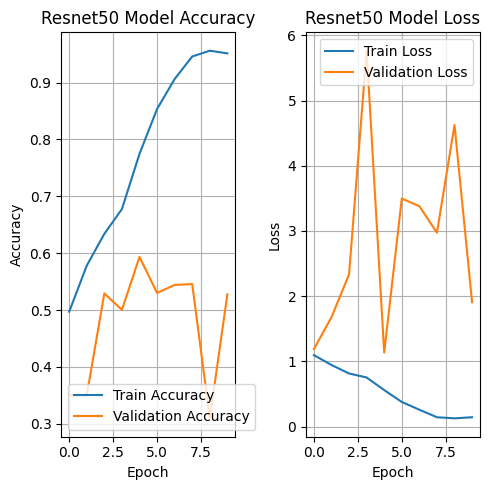

In [5]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(5, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Resnet50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Resnet50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [6]:
test_loss, test_acc = resnet_model.evaluate(test_data)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.5355 - loss: 1.8146
Test Loss: 1.907828450202942
Test Accuracy: 0.5277560353279114


In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Predict the classes on the test set
predictions = resnet_model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print(conf_matrix)

# Generate classification report
class_report = classification_report(true_classes, predicted_classes, target_names=test_data.class_indices.keys())
print(class_report)

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step
[[ 61   2  41  75]
 [  7   0   2   3]
 [212   8 184 236]
 [153   4 119 172]]
                  precision    recall  f1-score   support

    MildDemented       0.14      0.34      0.20       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.53      0.29      0.37       640
VeryMildDemented       0.35      0.38      0.37       448

        accuracy                           0.33      1279
       macro avg       0.26      0.25      0.24      1279
    weighted avg       0.41      0.33      0.34      1279

